# 6.3 Geospatial Analysis

## Contents

1. Importing libraries and data
2. Data Wrangling
    - deriving ['estimated_occupancy']
    - deriving ['EROR'], or Estimated by Reviews Occupancy Range
    - deriving ['estimated_revenue']

## 1. Importing Standard DA Libraries, Visualization Libraries + Libraries for Geospatial Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import folium
import json

In [3]:
%matplotlib inline

# This command prompts matplotlib visuals to appear in the notebook

In [85]:
atxgeo = r'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER/02 Data/Inside Airbnb/Austin.neighbourhoods.geojson'

In [86]:
atxgeo

'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER/02 Data/Inside Airbnb/Austin.neighbourhoods.geojson'

In [4]:
#Setting path to Achievement 6 master folder
path = r'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'
#checking path set correctly
path

'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'

In [5]:
# delimiting columns displayed
pd.options.display.max_columns = None

In [12]:
listings = pd.read_csv(os.path.join(path,'02 Data', 'Prepared Data','listings_entirespace.csv'), index_col = False)

In [13]:
listings.shape

(8764, 56)

In [14]:
listings.head()

Unnamed: 0     id                         listing_url  host_id  host_since  \
0           0   5456   https://www.airbnb.com/rooms/5456     8028  2009-02-16   
1           3   6448   https://www.airbnb.com/rooms/6448    14156  2009-04-20   
2           4   8502   https://www.airbnb.com/rooms/8502    25298  2009-07-11   
3           5  13035  https://www.airbnb.com/rooms/13035    50793  2009-11-02   
4           6  18258  https://www.airbnb.com/rooms/18258    39458  2009-09-18   

  host_response_rate host_acceptance_rate  host_is_superhost  \
0               100%                  97%               True   
1               100%                 100%               True   
2               100%                  50%               True   
3               100%                  93%               True   
4               100%                  96%               True   

  host_neighbourhood  host_listings_count  host_verifications  \
0      East Downtown                  1.0  ['email', 'phone']   
1             Zilker                  1.0  ['email', 'phone']   
2     East Riverside                  1.0  ['email', 'phone']   
3      East Downtown                  2.0  ['email', 'phone']   
4                NaN                  1.0  ['email', 'phone']   

  host_has_profile_pic host_identity_verified  neighbourhood_cleansed  \
0                    t                      t                   78702   
1                    t                      t                   78704   
2                    t                      f                   78741   
3                    t                      t                   78702   
4                    t                      t                   78745   

   latitude  longitude       property_type        room_type  accommodates  \
0  30.26057  -97.73441   Entire guesthouse  Entire home/apt             3   
1  30.26034  -97.76487   Entire guesthouse  Entire home/apt             2   
2  30.23466  -97.73682  Entire guest suite  Entire home/apt             2   
3  30.26098  -97.73072         Entire home  Entire home/apt             3   
4  30.19756  -97.78754     Entire bungalow  Entire home/apt             2   

  bathrooms_text  bedrooms  beds amenities    price  minimum_nights  \
0         1 bath       NaN   2.0        []  $101.00               2   
1         1 bath       NaN   2.0        []  $159.00               3   
2         1 bath       NaN   1.0        []   $48.00               4   
3        2 baths       NaN   2.0        []  $123.00              30   
4        2 baths       NaN   2.0        []  $100.00               3   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0              90                       2                       2   
1             365                       3                       3   
2              90                       4                      20   
3             180                      30                      30   
4              30                       3                       3   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                      90                      90                     2.0   
1                    1125                    1125                     3.0   
2                      90                      90                     7.2   
3                     180                     180                    30.0   
4                    1125                    1125                     3.0   

  has_availability  availability_30  availability_60  availability_90  \
0                t               21               51               74   
1                t               10               10               16   
2                t               15               45               75   
3                t                0                0                0   
4                t                0                0                0   

   availability_365  number_of_reviews  number_of_reviews_ltm  \
0               330          

## 2. Data Wrangling

- Wanting to evaluate Austin neighborhoods (done by zipcode) in terms of average revenue per listing. 

- Since we don't have an outright revenue column, we can derive it borrowing from the methodology outlined in Inside Airbnb's assumptions page.

- We'll derive an ['estimated occupancy'] metric by dividing ['reviews_per_month'] by 50% (in other words x2, times an average of 3 nights per stay.
    
    - might run a more sophisticated version of est. occupancy that uses the minimum nights for each listing when greater than 3 nights as the multiplier per stay, but I'd want to clean up the outliers before taking a run at it. 
    - For this first run, ['estimated_occupancy'] = ['reviews_per_month'] times 6, capped at 30 days/ full occupancy.
        - Inside Airbnb caps occupancy at 70% to remain conservative; their goal is to demonstrate the effect which Airbnb's might impact the local housing supply.
    
- Next we'll derive ['estimated revenue'] by multiplying ['price'] (*which can be changed by the host on a given date but for our purposes will remain static*) times ['estimated occupancy'].

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='reviews_per_month', ylabel='Count'>

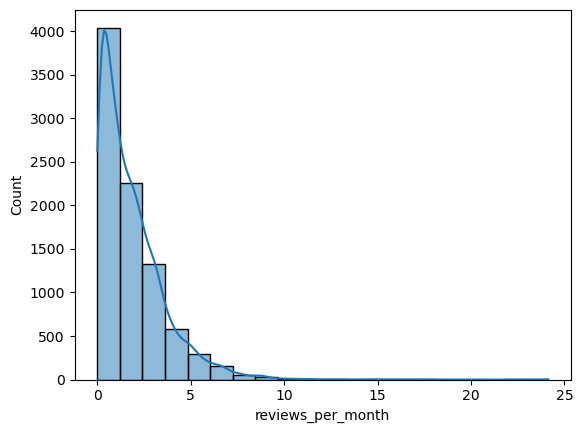

In [15]:
sns.histplot(listings['reviews_per_month'], bins = 20, kde = True)

In [21]:
listings['reviews_per_month'].value_counts()

reviews_per_month
1.00     130
0.07      78
0.14      70
0.04      69
0.55      66
        ... 
12.26      1
5.96       1
10.53      1
8.94       1
7.00       1
Name: count, Length: 773, dtype: int64

In [26]:
# Creating estimated occupancy variable (simple version)

listings['estimated_occupancy'] = listings['reviews_per_month']*6 

In [37]:


listings['estimated_occupancy'].value_counts(ascending = True, sort = False, dropna = True)

estimated_occupancy
22.26    13
12.54    22
1.80     42
0.72     42
8.64     14
         ..
26.58     1
90.00     1
38.82     1
39.30     1
42.00     1
Name: count, Length: 773, dtype: int64

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='estimated_occupancy', ylabel='Count'>

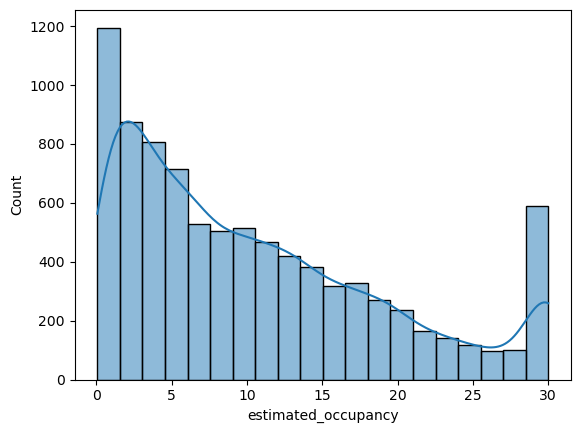

In [52]:
#based on the histogram, the majority of occupancy estimates sit below 20 days.
# minority of listings showing above 30 days, will correct them to full occupancy.

sns.histplot(listings['estimated_occupancy'], bins = 20, kde = True)

In [50]:
# Capping estimated occupancy to 30 days.

listings['estimated_occupancy'].values[listings['estimated_occupancy'].values > 30] = 30

In [54]:
listings['estimated_occupancy'].value_counts()

estimated_occupancy
30.00    513
6.00     130
0.42      78
0.84      70
0.24      69
        ... 
21.18      1
29.10      1
29.94      1
25.92      1
26.58      1
Name: count, Length: 498, dtype: int64

In [55]:
# Creating Estimated by Reviews Occupancy Range (EROR)

listings.loc[listings['estimated_occupancy'] < 1, 'EROR'] = 'Very low occupancy'
listings.loc[(listings['estimated_occupancy'] >= 1) & (listings['estimated_occupancy'] < 6),'EROR'] = 'Low occupancy'
listings.loc[(listings['estimated_occupancy'] >= 6) & (listings['estimated_occupancy'] < 30),'EROR'] = 'Medium occupancy'
listings.loc[listings['estimated_occupancy'] >= 30, 'EROR'] = 'High occupancy'


/var/folders/12/fz0w81fd1mb1hklwgzyg3bx00000gn/T/ipykernel_64230/3650933880.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Very low occupancy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  listings.loc[listings['estimated_occupancy'] < 1, 'EROR'] = 'Very low occupancy'


In [56]:
listings['EROR'].value_counts(dropna = False)

EROR
Medium occupancy      4790
Low occupancy         2647
Very low occupancy     814
High occupancy         513
Name: count, dtype: int64

### Deriving Estimated Revenue

Need to clean ['price'] variable:
- remove dollar sign, change to float64
- will also remove outliers.

In [58]:
listings['price'].dtype

dtype('O')

In [59]:
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].astype(float)

In [64]:
# Removing price outliers, which throw est_rev bins out of whack

q = listings['price'].quantile(0.99)

In [65]:
listings = listings[listings['price']<q]

In [66]:
listings['estimated_revenue'] = listings['estimated_occupancy']*listings['price']

In [67]:
listings.head()

Unnamed: 0     id                         listing_url  host_id  host_since  \
0           0   5456   https://www.airbnb.com/rooms/5456     8028  2009-02-16   
1           3   6448   https://www.airbnb.com/rooms/6448    14156  2009-04-20   
2           4   8502   https://www.airbnb.com/rooms/8502    25298  2009-07-11   
3           5  13035  https://www.airbnb.com/rooms/13035    50793  2009-11-02   
4           6  18258  https://www.airbnb.com/rooms/18258    39458  2009-09-18   

  host_response_rate host_acceptance_rate  host_is_superhost  \
0               100%                  97%               True   
1               100%                 100%               True   
2               100%                  50%               True   
3               100%                  93%               True   
4               100%                  96%               True   

  host_neighbourhood  host_listings_count  host_verifications  \
0      East Downtown                  1.0  ['email', 'phone']   
1             Zilker                  1.0  ['email', 'phone']   
2     East Riverside                  1.0  ['email', 'phone']   
3      East Downtown                  2.0  ['email', 'phone']   
4                NaN                  1.0  ['email', 'phone']   

  host_has_profile_pic host_identity_verified  neighbourhood_cleansed  \
0                    t                      t                   78702   
1                    t                      t                   78704   
2                    t                      f                   78741   
3                    t                      t                   78702   
4                    t                      t                   78745   

   latitude  longitude       property_type        room_type  accommodates  \
0  30.26057  -97.73441   Entire guesthouse  Entire home/apt             3   
1  30.26034  -97.76487   Entire guesthouse  Entire home/apt             2   
2  30.23466  -97.73682  Entire guest suite  Entire home/apt             2   
3  30.26098  -97.73072         Entire home  Entire home/apt             3   
4  30.19756  -97.78754     Entire bungalow  Entire home/apt             2   

  bathrooms_text  bedrooms  beds amenities  price  minimum_nights  \
0         1 bath       NaN   2.0        []  101.0               2   
1         1 bath       NaN   2.0        []  159.0               3   
2         1 bath       NaN   1.0        []   48.0               4   
3        2 baths       NaN   2.0        []  123.0              30   
4        2 baths       NaN   2.0        []  100.0               3   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0              90                       2                       2   
1             365                       3                       3   
2              90                       4                      20   
3             180                      30                      30   
4              30                       3                       3   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                      90                      90                     2.0   
1                    1125                    1125                     3.0   
2                      90                      90                     7.2   
3                     180                     180                    30.0   
4                    1125                    1125                     3.0   

  has_availability  availability_30  availability_60  availability_90  \
0                t               21               51               74   
1                t               10               10               16   
2                t               15               45               75   
3                t                0                0                0   
4                t                0                0                0   

   availability_365  number_of_reviews  number_of_reviews_ltm  \
0               330                668   

In [68]:
listings['estimated_revenue'].value_counts(dropna = False)

estimated_revenue
2430.00    14
2370.00    14
2070.00    13
2700.00    13
2850.00    13
           ..
2400.84     1
1881.60     1
69.42       1
1590.48     1
402.00      1
Name: count, Length: 6782, dtype: int64

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='estimated_revenue', ylabel='Count'>

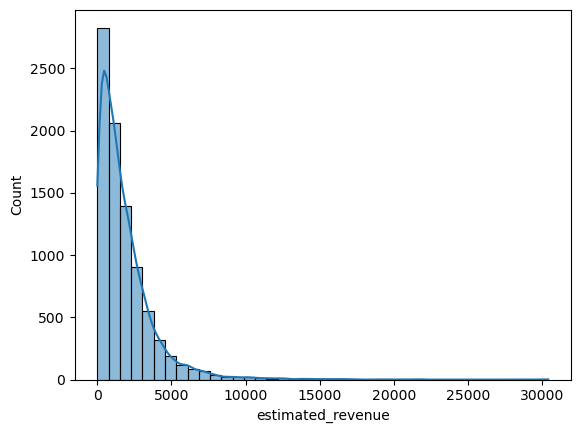

In [70]:
sns.histplot(listings['estimated_revenue'], bins = 40, kde = True)

### 3. Data Cleaning

- as mentioned, data cleaning for price is above.
- Will remove lower outliers for reviews per month as well.

In [71]:
listings['reviews_per_month'].value_counts(ascending = True)

reviews_per_month
7.00       1
9.91       1
24.13      1
6.11       1
6.92       1
        ... 
0.55      65
0.04      66
0.14      67
0.07      77
1.00     130
Name: count, Length: 773, dtype: int64

In [72]:
z = listings['reviews_per_month'].quantile(0.01)

In [73]:
listings = listings[listings['reviews_per_month']>z]

In [74]:
listings.shape

(8576, 60)

In [76]:
# Verifying dtype for the key to the json

listings['neighbourhood_cleansed'].dtype

dtype('int64')

### 4. Plotting a chloropleth

In [80]:
# Create a df with just the neighborhoods and values for rating we want plotted

zip_by_revenue = listings[['neighbourhood_cleansed', 'estimated_revenue']]
zip_by_revenue.head()

neighbourhood_cleansed  estimated_revenue
0                   78702            2248.26
1                   78704            1993.86
2                   78741              86.40
3                   78702              88.56
4                   78745             864.00

In [90]:
listings['estimated_revenue'].dtype

dtype('float64')

In [ ]:
# Finding GeoJSON keys



In [134]:
# Setup a folium map at Austin TX
map = folium.Map(location = [30.2666, -97.73330], zoom_start = 9)

# Choropleth maps bind Pandas Data Frames and json geometries.This allows us to quickly visualize data combinations
folium.Choropleth(
    geo_data = atxgeo, 
    data = zip_by_revenue,
    columns = ['neighbourhood_cleansed', 'estimated_revenue'],
    key_on = "feature.properties.neighbourhood",
    fill_color = 'YlOrBr', fill_opacity=0.6, line_opacity=0.1,
    legend_name = "estimated revenue").add_to(map)
folium.LayerControl().add_to(map)

map


### Results analysis:

The neighborhoods in this dataset are just the boundaries of the various zipcodes in ATX, so not as granular as I would hope BUT... this does answer some research questions I posed at the outset of the analysis. 

In particular, where are the highest earning listings in Austin Texas. Need to figure out how to do an overlay so I don't mistakenly crossreference these neighborhoods versus this map I'm using for reference.

78746 being darker/ in the 3000+ range makes sense, with its large swathe on the River, but the dark spot north of downtown and West Campus, what looks like 78757, not clear what set this neighborhood aside as such an outlier earner, with an average of over 5000 in revenue per month. Will investigate further if it's due to a few high earning outliers (even though we cleaned the data of the top 1% of listings by price), or if there's really just a hot spot there for whatever reason.

The next one that jumps out is at the north of the greater Austin metroplex, pretty firmly in Round Rock at 78717. Appears to be relatively affluent, suburban - again we would have to drill into the listings data to discover whether or not the darker cloropleth shade is due to a few high earners with few average/low earning listings, or some alternative.

Interesting stuff though! Lots of research to do about the various zip codes in regards to income, 'fun factor', and airbnb inventory.